In [2]:
import numpy as np
import math as m
from scipy.integrate import odeint
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

\begin{align*}
\begin{bmatrix}
\dot{x} \\ \dot{y} \\ \dot{\theta}
\end{bmatrix}&= \begin{bmatrix}
\frac{r}{2}(u_r + u_l)\cos\theta \\
\frac{r}{2}(u_r + u_l)\sin\theta \\
\frac{r}{L}(u_r - u_l)
\end{bmatrix}
\end{align*}

In [107]:
r = 0.025 #radius of wheels
L = 0.09 # length of axle
W = 0.1 # width of robot
l = L/3.
#r = 0.5
#L = 1.
#W = 1.
radian_vel_limit = 2*np.pi

radian_input_limit = 2*np.pi

op_space_xmin = 0.
op_space_xmax = 0.75
op_space_ymin = 0.
op_space_ymax = 0.5

V_max = 2*np.pi*r # maximum forward velocity in any direction

#process noise variances
input_variance = (0.05*radian_vel_limit)**2

#measurement variances
distance_measurement_variance = (0.9*0.03)**2
theta_measurement_variance = (2*np.pi/9600)**2
theta_dot_measurement_variance = ((0.1)*np.pi/180)**2

# function describing system dynamics
# xdot = f(x,u)
def dynamics(x,t,u):
    global r
    global L
    xdot = r*np.cos(x[2])*(u[0]+x[3]+u[1]+x[4])/2.0
    ydot = r*np.sin(x[2])*(u[0]+x[3]+u[1]+x[4])/2.0
    theta_dot = (r/L)*((u[1]+x[3])-(u[0]+x[4]))
    nu_dot = np.random.normal(0,np.sqrt(input_variance),2)
    return np.array([xdot,ydot,theta_dot,nu_dot[0],nu_dot[1]])
    #return np.array([xdot,ydot,theta_dot,0,0])

def wrap_angle(theta):
    return (theta + np.pi) % (2 * np.pi) - np.pi

def get_output(x,u):
    y = np.empty(4)
    y[0] = x[2] + np.random.normal(loc=0,scale=np.sqrt(theta_measurement_variance))
    y[1] = r/L*(u[1]-u[0]) + np.random.normal(loc=0,scale=np.sqrt(theta_dot_measurement_variance))
    eps = np.finfo(float).eps
    theta = wrap_angle(x[2])
    #parallel and perpendicular vectors
    par = np.array([np.cos(x[2]), np.sin(x[2])])
    perp_angle = wrap_angle(x[2]-np.pi/2.)
    perp = np.array([np.cos(perp_angle),np.sin(perp_angle)])
    
    #compute forward distance to a wall
    if abs(par[0]) <= eps :
        c = max((op_space_ymax-x[1]), (op_space_ymin-x[1]))
    elif abs(par[1]) <= eps :
        c = max((op_space_xmax-x[0]), (op_space_xmin-x[0]))
    else:    
        if (0 < theta <= np.pi/2.) :
            c = min((op_space_xmax-x[0])/par[0], (op_space_ymax-x[1])/par[1])
        elif (np.pi/2 < x[2] <= np.pi) :
            c = min((op_space_xmin-x[0])/par[0], (op_space_ymax-x[1])/par[1])
        elif (-np.pi < theta <= -np.pi/2.) :
            c = min((op_space_xmin-x[0])/par[0], (op_space_ymin-x[1])/par[1])
        elif (-np.pi/2 < theta <= 0) :
            c = min((op_space_xmax-x[0])/par[0], (op_space_ymin-x[1])/par[1])
    y[2] = c + np.random.normal(loc=0,scale=np.sqrt(distance_measurement_variance))
    
    #compute rightward distance to a wall
    if abs(perp[0]) <= eps :
        c = max((op_space_ymax-x[1]), (op_space_ymin-x[1]))
    elif abs(perp[1]) <=eps :
        c = max((op_space_xmax-x[0]), (op_space_xmin-x[0]))
    else :
        if (0 < theta <= np.pi/2.) :
            c = min((op_space_xmax-x[0])/perp[0], (op_space_ymin-x[1])/perp[1])
        elif (np.pi/2 < theta <= np.pi) :
            c = min((op_space_xmax-x[0])/perp[0], (op_space_ymax-x[1])/perp[1])
        elif (-np.pi < theta <= -np.pi/2.) :
            c = min((op_space_xmin-x[0])/perp[0], (op_space_ymax-x[1])/perp[1])
        elif (-np.pi/2 < theta <= 0) :
            c = min((op_space_xmin-x[0])/perp[0], (op_space_ymin-x[1])/perp[1])
    y[3] = c + np.random.normal(loc=0,scale=np.sqrt(distance_measurement_variance))
    return y

def delta_angle(x_1,x_2):
    vect = (x_2[0:2]-x_1[0:2])/(np.linalg.norm(x_2[0:2]-x_1[0:2])) # normalized vector pointing between points
    current_orient = np.array([np.cos(x_1[2]), np.sin(x_1[2])])
    sin_value = np.clip(np.cross(current_orient,vect),-1.,1.)
    cos_value = np.clip(np.dot(vect,current_orient),-1.,1.)
    return m.copysign(np.arccos(cos_value),sin_value)

def compute_input(state_1,state_2):
    angle_diff = delta_angle(state_1,state_2)
    u_r = (V_max/r)*(np.cos(angle_diff) - (L/(2*l))*np.sin(angle_diff))
    u_l = (V_max/r)*(np.cos(angle_diff) + (L/(2*l))*np.sin(angle_diff))
    u = np.array([u_r,u_l])
    if any(abs(u) > radian_input_limit):
        u *= radian_input_limit/max(abs(u))
    return u

def t_sec_trajectory_constant_input(x_0,x_d,u_input,t):
    steps = m.ceil(t*100) #100 steps per second
    sub_steps = 50
    x = np.zeros([5,steps+1])
    y = np.zeros([4,steps+1])
    u = np.zeros([2,steps+1])
    t = np.linspace(0.,t/steps,sub_steps)
    x[:,0] = x_0
    for step in range(steps):
        u[:,step] = u_input
        y[:,step] = get_output(x[:,step],u[:,step])
        sol = odeint(dynamics,x[:,step],t,args=(u[:,step],))
        x[:,step+1] = sol[-1,:]
    u[:,step+1] = compute_input(x[:,step+1],x_d)
    y[:,step+1] = get_output(x[:,step+1],u[:,step+1])
    return x,y

def t_sec_trajectory(x_0,x_d,t):
    steps = m.ceil(t*100) #100 steps per second
    sub_steps = 20
    x = np.zeros([5,steps+1])
    y = np.zeros([4,steps+1])
    u = np.zeros([2,steps+1])
    t = np.linspace(0.,t/steps,sub_steps)
    x[:,0] = x_0
    for step in range(steps):
        u[:,step] = compute_input(x[:,step],x_d)
        y[:,step] = get_output(x[:,step],u[:,step])
        sol = odeint(dynamics,x[:,step],t,args=(u[:,step],))
        x[:,step+1] = sol[-1,:]
    u[:,step+1] = compute_input(x[:,step+1],x_d)
    y[:,step+1] = get_output(x[:,step+1],u[:,step+1])
    return x,y,u

def t_sec_trajectory_quick(x_0,x_d,t):
    steps = m.ceil(t*30) #30 steps per second
    sub_steps = 10
    x = np.zeros(5)
    y = np.zeros(4)
    u = np.zeros(2)
    t = np.linspace(0.,t/steps,sub_steps)
    x = x_0
    for step in range(steps):
        u = compute_input(x,x_d)
        #y[:,0] = get_output(x[:,step],u[:,step])
        x = odeint(dynamics,x,t,args=(u,))[-1,:]
    u = compute_input(x,x_d)
    y = get_output(x,u)
    return x,y

def plot_trajectory(x,y):
    f = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    steps = np.shape(x)[1]
    ax.scatter(x[0,0],x[1,0],marker='*',color='green',s=800) # plot green square at initial point
    ax.plot(x[0,0:steps],x[1,0:steps])
    ax.plot([op_space_xmin,op_space_xmax],[0,0],color='black',linewidth=5)
    ax.plot([op_space_xmin,op_space_xmax],[op_space_ymax,op_space_ymax],color='black',linewidth=5)
    ax.plot([0,0],[op_space_ymin,op_space_ymax],color='black',linewidth=5)
    ax.plot([op_space_xmax,op_space_xmax],[op_space_ymin,op_space_ymax],color='black',linewidth=5)
    for hop in range(0,steps,5):
        ax.quiver(x[0,hop],x[1,hop],np.cos(x[2,hop]),np.sin(x[2,hop]))
        
        par_point = np.array([np.cos(x[2,hop])*y[2,hop]+x[0,hop], np.sin(x[2,hop])*y[2,hop]+x[1,hop]])
        perp_point = np.array([np.cos(x[2,hop]-np.pi/2.)*y[3,hop]+x[0,hop], np.sin(x[2,hop]-np.pi/2.)*y[3,hop]+x[1,hop]])
        par_line = np.array([[x[0,hop],x[1,hop]],par_point])
        perp_line = np.array([[x[0,hop],x[1,hop]],perp_point])
        ax.plot(par_line[:,0],par_line[:,1],color='red',alpha=0.4)
        ax.plot(perp_line[:,0],perp_line[:,1],color='blue',alpha=0.4)

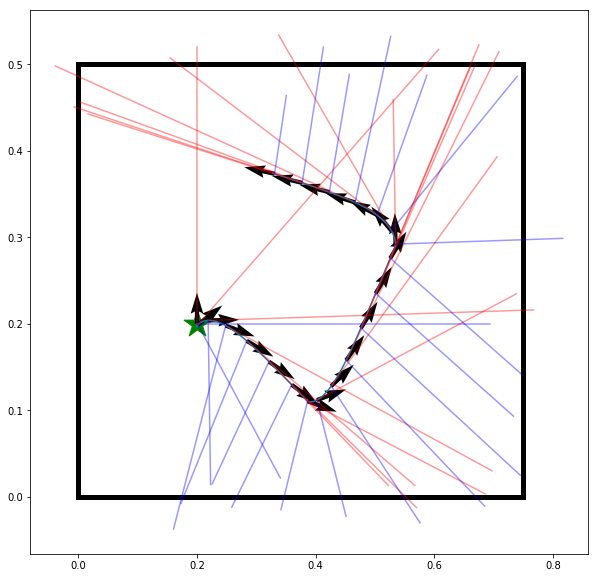

In [104]:
x_0 = np.array([0.2,0.2,np.pi/2.,0,0])
x_d = np.array([[0.4,0.1,0,0,0],
                [0.6,0.4,0,0,0],
                [0.2,0.4,0,0,0]])
t = 2.0

#print(delta_angle(x_0,x_d)/np.pi)

(x1,y1,_) = t_sec_trajectory(x_0,x_d[0,:],t)
(x2,y2,_) = t_sec_trajectory(x1[:,-1],x_d[1,:],t)
(x3,y3,_) = t_sec_trajectory(x2[:,-1],x_d[2,:],t)
x = np.concatenate((x1,x2,x3),axis=1)
y = np.concatenate((y1,y2,y3),axis=1)
plot_trajectory(x,y)
plt.savefig('measurements_with_noise.png')

In [35]:
x_0 = np.array([0.1,0.1,0,0,0])
x_d = np.array([0.6,0.4,0,0,0])
#P_0 = np.zeros([5,5])
P_0 = np.diag(0.001*np.ones(5))

#process_noise_covariance = np.zeros([3,3])
process_noise_covariance = np.zeros([5,5])
process_noise_covariance[3,3] = input_variance
process_noise_covariance[4,4] = input_variance

#process_noise_covariance = np.array([[0.00001,0,0],
#                                     [0,0.00001,0],
#                                     [0,0,0.00001]])

output_noise_covariance = np.zeros([4,4])
output_noise_covariance[0,0] = theta_measurement_variance
output_noise_covariance[1,1] = theta_dot_measurement_variance
output_noise_covariance[2,2] = distance_measurement_variance
output_noise_covariance[3,3] = distance_measurement_variance

#output_noise_covariance = np.array([[0.00001,0,0,0],
#                                    [0,0.00001,0,0],
#                                    [0,0,0.00001,0],
#                                    [0,0,0,0.00001]])
state_min = np.array([op_space_xmin, op_space_ymin, -np.pi, -np.inf, -np.inf])
state_max = np.array([op_space_xmax, op_space_ymax, np.pi, np.inf, np.inf])

#Initialize parameters
steps = 100
delta_t = 0.1 #seconds/step
n = 5
sigma_points = np.empty([5,2*n+1,steps]) #sigma points to evolve
z = np.empty([4,2*n+1,steps]) #outputs
w = np.empty([2*n+1]) #weights of sigma points
state_cov = np.empty([5,5]) #covariances of state forecast
output_cov = np.empty([4,4])#covariance of output forecast
cross_cov = np.empty([5,4])
P = np.empty([5,5,steps])

real_x = np.empty([5,steps])
real_z = np.empty([4,steps])

P[:,:,0] = P_0
sigma_points[:,0,0] = x_0
real_x[:,0] = x_0
w[0] = -0.99
for i in range(2*n+1):
    w[i] = (1-w[0])/(2*n)
S = np.linalg.cholesky(np.sqrt(n/(1-w[0]))*P[:,:,0])

u = np.empty([2,2*n+1])

for t in range(1,steps):
    print('T-STEP',t)
    start = time.time()
    #########################################################
    #                  SELECT SIGMA POINTS                  #
    #########################################################
    S = np.linalg.cholesky((n/(1-w[0]))*P[:,:,t-1]) 
    for i in range(n):
        sigma_points[:,i+1,t-1] = np.clip(sigma_points[:,0,t-1] + S[:,i], state_min, state_max)
    for i in range(n):
        sigma_points[:,n+i+1,t-1] = np.clip(sigma_points[:,0,t-1] - S[:,i], state_min, state_max)
    #print('Selected points in %s seconds' %(time.time()-start))
    #########################################################
    #                  EVOLVE SIGMA POINTS                  #
    #########################################################
    #Evolve sigma points through process and extract output
    start = time.time()
    for i in range(2*n+1):
        sigma_points[:,i,t],z[:,i,t] = t_sec_trajectory_quick(sigma_points[:,i,t-1],x_d,delta_t) #evolve sigma point
    #print('evolved points in %s seconds' %(time.time()-start))
    #Compute new mean of sigma point states and outputs
    start = time.time()
    avg_state = np.average(sigma_points[:,:,t], axis=1, weights=w)
    avg_output = np.average(z[:,:,t], axis=1, weights=w)

    #Compute new covariances of evolved states, outputs, and their cross-covariances
    state_cov = np.zeros([5,5])
    output_cov = np.zeros([4,4])
    cross_cov = np.zeros([5,4])
    for i in range(2*n+1):
        state_cov += w[i]*np.outer(sigma_points[:,i,t]-avg_state, sigma_points[:,i,t]-avg_state)
        output_cov += w[i]*np.outer(z[:,i,t]-avg_output,z[:,i,t]-avg_output)
        cross_cov += w[i]*np.outer(sigma_points[:,i,t]-avg_state,z[:,i,t]-avg_output)
    state_cov += process_noise_covariance
    output_cov += output_noise_covariance
    #print('computed new covariances in %s seconds' %(time.time()-start))
    
    #true evolution of state
    real_u = compute_input(real_x[:,t-1],x_d)
    real_x[:,t],real_z[:,t] = t_sec_trajectory_quick(real_x[:,t-1],x_d,delta_t)
    print('REAL STATE at time %s : %s' %(t,real_x[:,t]))
    
    start = time.time()
    K = np.matmul(cross_cov,np.linalg.inv(output_cov))
    sigma_points[:,0,t] = avg_state + np.matmul(K,real_z[:,t]-avg_output)
    sigma_points[2,0,t] = wrap_angle(sigma_points[2,0,t])
    sigma_points[:,0,t] = np.clip(sigma_points[:,0,t],state_min,state_max)
    P[:,:,t] = state_cov - np.matmul(np.matmul(K,output_cov),np.transpose(K))
    #print('computed estimate in %s seconds' %(time.time()-start))
    print('ESTIMATED STATE at time %s : %s' %(t,sigma_points[:,0,t]))
    P[:,:,t] = 0.5*(P[:,:,t] + np.transpose(P[:,:,t]))

    

T-STEP 1
REAL STATE at time 1 : [ 0.10869753  0.1007114   0.15475362 -0.01033474 -0.00998087]
ESTIMATED STATE at time 1 : [0.10774662 0.09730463 0.15435423 0.0107962  0.01674417]
T-STEP 2
REAL STATE at time 2 : [ 0.11850915  0.10290272  0.27763549 -0.06183214 -0.01031676]
ESTIMATED STATE at time 2 : [0.10782338 0.0964051  0.27824521 0.04696294 0.10550004]
T-STEP 3
REAL STATE at time 3 : [ 0.12927511  0.10655641  0.37121945 -0.03360008 -0.02079668]
ESTIMATED STATE at time 3 : [ 0.11630695  0.09872724  0.36925361 -0.08341361  0.16739315]
T-STEP 4
REAL STATE at time 4 : [ 0.14078002  0.11152818  0.44038815 -0.00959224 -0.04029167]
ESTIMATED STATE at time 4 : [ 0.1284701   0.10415832  0.44012063 -0.03948313  0.02030631]
T-STEP 5
REAL STATE at time 5 : [ 0.15287185  0.11761326  0.48881887  0.00556951 -0.04699509]
ESTIMATED STATE at time 5 : [ 0.14760896  0.11429465  0.4884458  -0.05673956 -0.004027  ]
T-STEP 6
REAL STATE at time 6 : [ 0.16537804  0.12454118  0.52058296  0.00830546 -0.040963

REAL STATE at time 46 : [ 0.59816193  0.39767212  0.87152213 -0.11156062 -0.01690559]
ESTIMATED STATE at time 46 : [ 0.59819535  0.39771212  0.87119047 -0.11690228  0.05844886]
T-STEP 47
REAL STATE at time 47 : [ 0.60134019  0.40150969  0.88655428 -0.0805355  -0.01323235]
ESTIMATED STATE at time 47 : [ 0.60145113  0.40164634  0.88683246 -0.11863365  0.07456127]
T-STEP 48
REAL STATE at time 48 : [ 0.59823129  0.39763699  0.90217128 -0.10018455  0.00274591]
ESTIMATED STATE at time 48 : [ 0.59817619  0.39756868  0.90311537 -0.14839146 -0.10648758]
T-STEP 49
REAL STATE at time 49 : [ 0.60131332  0.40158369  0.91342287 -0.11713524  0.02202924]
ESTIMATED STATE at time 49 : [ 0.60110021  0.40130927  0.912327   -0.15282123 -0.13315066]
T-STEP 50
REAL STATE at time 50 : [ 0.59828585  0.39761274  0.92534245 -0.07159239  0.03491451]
ESTIMATED STATE at time 50 : [ 0.59835028  0.39769568  0.92604467 -0.02329404  0.13407083]
T-STEP 51
REAL STATE at time 51 : [ 0.60132524  0.40168763  0.93449164 -0.0

REAL STATE at time 90 : [ 0.59998958  0.39993847  1.3305588  -0.19033184 -0.23544842]
ESTIMATED STATE at time 90 : [ 0.60010111  0.40045636  1.33134702 -0.05991753 -0.03920552]
T-STEP 91
REAL STATE at time 91 : [ 0.60089163  0.40378487  1.35056867 -0.18633112 -0.23896087]
ESTIMATED STATE at time 91 : [ 0.59848458  0.39349945  1.34731377 -0.17139864  0.19130785]
T-STEP 92
REAL STATE at time 92 : [ 0.59965688  0.39811874  1.36198375 -0.17933121 -0.23081126]
ESTIMATED STATE at time 92 : [ 0.59939761  0.39746262  1.36106687 -0.23773213 -0.9077367 ]
T-STEP 93
REAL STATE at time 93 : [ 0.60055523  0.4025058   1.37563464 -0.16959626 -0.22036359]
ESTIMATED STATE at time 93 : [ 0.59989475  0.39941314  1.37524585 -0.12400703 -0.40564966]
T-STEP 94
REAL STATE at time 94 : [ 0.59952039  0.39708206  1.38895171 -0.17054421 -0.21431808]
ESTIMATED STATE at time 94 : [ 0.60153506  0.40791429  1.38996701 -0.05913539  0.01328255]
T-STEP 95
REAL STATE at time 95 : [ 0.60034218  0.40170243  1.40050886 -0.1

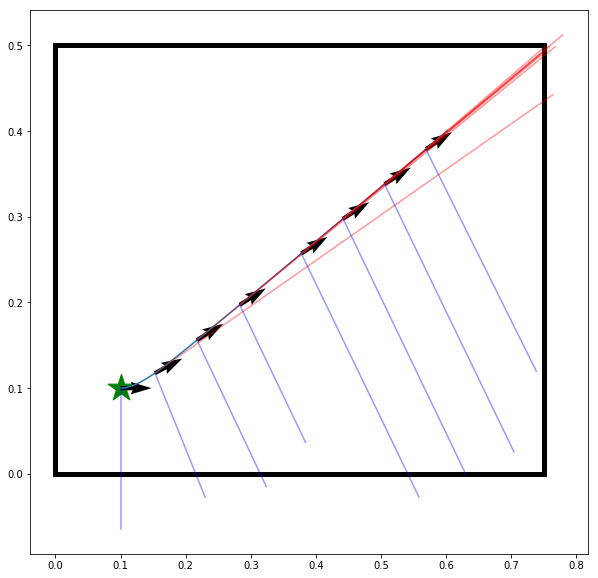

In [115]:
plot_trajectory(real_x[:,0:40],real_z[:,0:40])
plt.savefig('reference_traj.png')

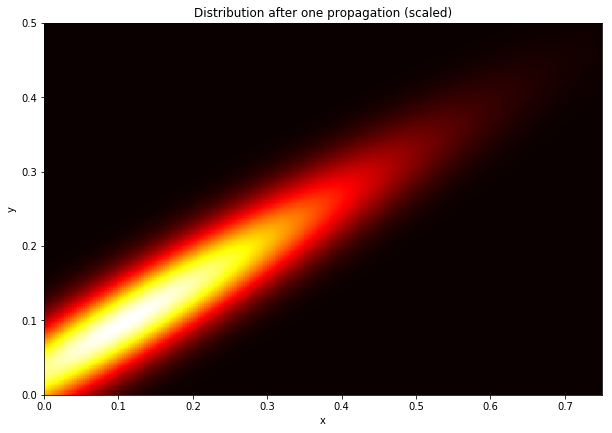

In [130]:
#pt = np.array([0.2,0.2])
xaxis = np.linspace(op_space_xmin,op_space_xmax,300)
yaxis = np.linspace(op_space_ymin,op_space_ymax,300)
X,Y = np.meshgrid(xaxis,yaxis)
Z = np.zeros(X.shape)

step = 1

mu = sigma_points[0:2,0,step]
sigma = 1e2*P[0:2,0:2,step]
var = multivariate_normal(mean=mu,cov=sigma)
for i in range(300):
    for j in range(300):
        Z[i,j] = var.pdf(x=np.array([X[i,j],Y[i,j]]))

f = plt.figure(figsize=(10,10))
ax = plt.subplot()
ax.imshow(Z, cmap='hot', interpolation='nearest',origin='lower',extent=(op_space_xmin,op_space_xmax,op_space_ymin,op_space_ymax))          
plt.xlabel('x')
plt.ylabel('y')
plt.title('Distribution after one propagation (scaled)')
plt.savefig('distribution_t1.png')
plt.show()


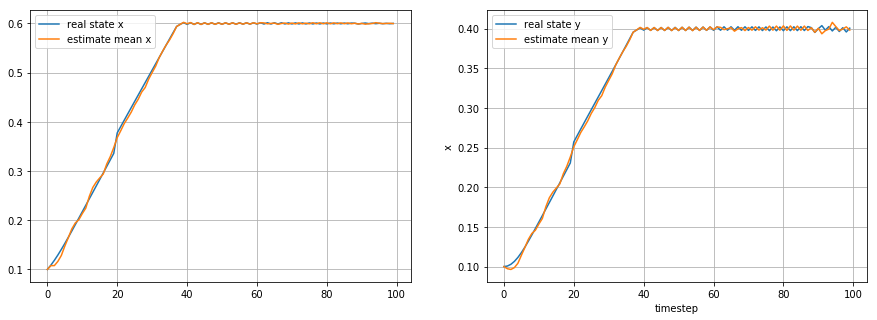

In [75]:
#f = plt.figure(figsize=(8,20))
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(real_x[0,:],label='real state x')
ax1.plot(sigma_points[0,0,:],label='estimate mean x')
ax1.grid()
ax2.plot(real_x[1,:],label='real state y')
ax2.plot(sigma_points[1,0,:],label='estimate mean y')
ax2.grid()
plt.xlabel('timestep')
plt.ylabel('x')
ax1.legend()
ax2.legend()
plt.savefig('tracking_pic.png')
plt.show()

No handles with labels found to put in legend.


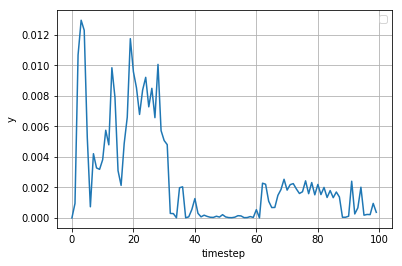

In [79]:
#plt.plot(real_x[1,:],label='real state y')
#plt.plot(sigma_points[1,0,:],label='estimated y')
plt.plot(abs(real_x[0,:]-sigma_points[0,0,:]))
plt.xlabel('timestep')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

Text(0, 0.5, 'y')

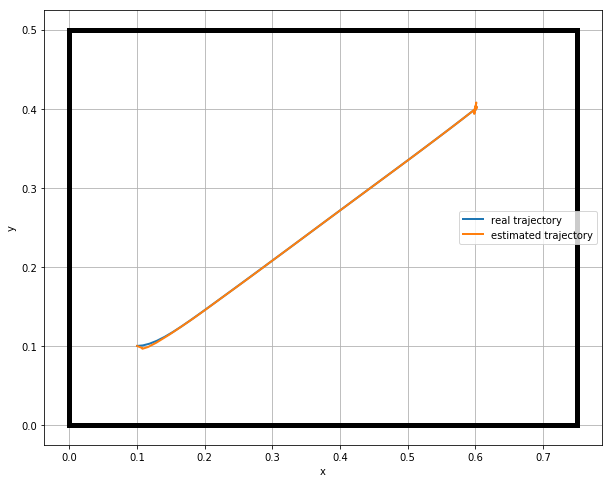

In [46]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot()
ax.plot(real_x[0,:],real_x[1,:],label='real trajectory',linewidth=2)
ax.plot(sigma_points[0,0,:],sigma_points[1,0,:],label='estimated trajectory',linewidth=2)
ax.plot([op_space_xmin,op_space_xmax],[0,0],color='black',linewidth=5)
ax.plot([op_space_xmin,op_space_xmax],[op_space_ymax,op_space_ymax],color='black',linewidth=5)
ax.plot([0,0],[op_space_ymin,op_space_ymax],color='black',linewidth=5)
ax.plot([op_space_xmax,op_space_xmax],[op_space_ymin,op_space_ymax],color='black',linewidth=5)
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

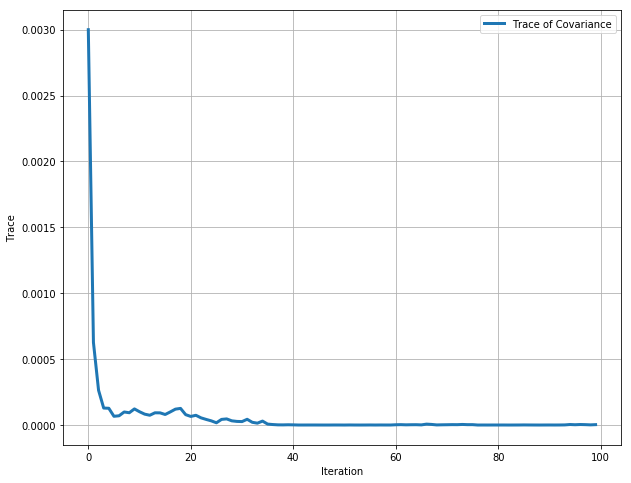

In [50]:
traces = np.empty(steps)
for i in range(steps):
    traces[i] = np.trace(P[0:3,0:3,i])
f = plt.figure(figsize=(10,8))
ax = plt.subplot()
ax.plot(traces,linewidth=3,label='Trace of Covariance')
plt.xlabel('Iteration')
plt.ylabel('Trace')
plt.grid()
plt.legend()
plt.savefig('trace_plot.png')
plt.show()